In [64]:
#this is the latest version


from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from itertools import product
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

RSEED=42



In [65]:
df_tanzania=pd.read_csv("data/Train.csv")
variable_features=pd.read_csv("data/VariableDefinitions.csv")

In [66]:
variable_features

,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


In [67]:
X = df_tanzania.drop(['total_cost','ID', "most_impressing"],axis=1)
y = df_tanzania.total_cost

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [69]:
df_tanzania_train = X_train.join(y_train)

In [70]:
df_tanzania_train.columns

Index(['country', 'age_group', 'travel_with', 'total_female', 'total_male',
       'purpose', 'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode',
       'first_trip_tz', 'total_cost'],
      dtype='object')

In [71]:
df_tanzania_train.isnull().sum()

country                    0
age_group                  0
travel_with              833
total_female               1
total_male                 4
purpose                    0
main_activity              0
info_source                0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
night_mainland             0
night_zanzibar             0
payment_mode               0
first_trip_tz              0
total_cost                 0
dtype: int64

In [72]:
df_tanzania_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3606 entries, 3075 to 860
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                3606 non-null   object 
 1   age_group              3606 non-null   object 
 2   travel_with            2773 non-null   object 
 3   total_female           3605 non-null   float64
 4   total_male             3602 non-null   float64
 5   purpose                3606 non-null   object 
 6   main_activity          3606 non-null   object 
 7   info_source            3606 non-null   object 
 8   tour_arrangement       3606 non-null   object 
 9   package_transport_int  3606 non-null   object 
 10  package_accomodation   3606 non-null   object 
 11  package_food           3606 non-null   object 
 12  package_transport_tz   3606 non-null   object 
 13  package_sightseeing    3606 non-null   object 
 14  package_guided_tour    3606 non-null   object 
 15  package

In [73]:
unique_values = X_train.apply(lambda col: col.unique())
print('unique:',unique_values)

unique: country                  [SOUTH AFRICA, KENYA, POLAND, IRELAND, UNITED ...
age_group                                        [25-44, 1-24, 45-64, 65+]
travel_with              [nan, Spouse and Children, Spouse, Friends/Rel...
total_female             [0.0, 2.0, 1.0, 4.0, 6.0, 3.0, 7.0, 5.0, 10.0,...
total_male               [1.0, 2.0, 0.0, 3.0, 4.0, 5.0, 6.0, nan, 9.0, ...
purpose                  [Meetings and Conference, Leisure and Holidays...
main_activity            [Wildlife tourism, Beach tourism, Hunting tour...
info_source              [Friends, relatives, Radio, TV, Web, Travel, a...
tour_arrangement                               [Independent, Package Tour]
package_transport_int                                            [No, Yes]
package_accomodation                                             [No, Yes]
package_food                                                     [No, Yes]
package_transport_tz                                             [No, Yes]
package_sightseei

In [74]:
unique_values.to_csv('data/unique_Value_train_features.csv')

In [75]:
df_tanzania_train.shape

(3606, 21)

Impute male and female:

In [76]:
df_tanzania_train['total_female'].fillna(round(df_tanzania_train['total_female'].mean()), inplace=True)

In [77]:
df_tanzania_train['total_female']
df_tanzania_train['total_female'].isnull().sum()

0

In [78]:
df_tanzania_train['total_male'].fillna(round(df_tanzania_train['total_male'].mean()), inplace=True)
df_tanzania_train['total_male'].isnull().sum()

0

Encoding:

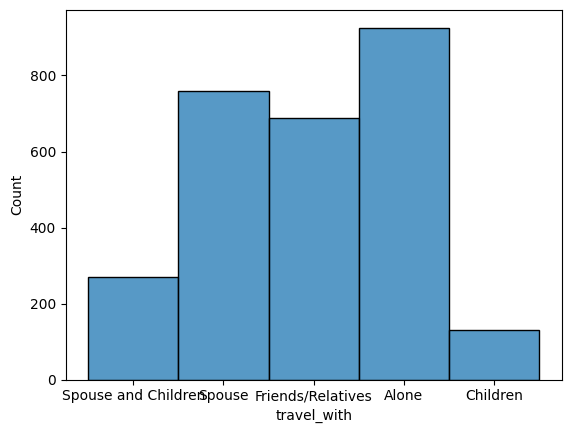

In [79]:
#travel_with
sns.histplot(df_tanzania_train.travel_with)
plt.show()

<Axes: >

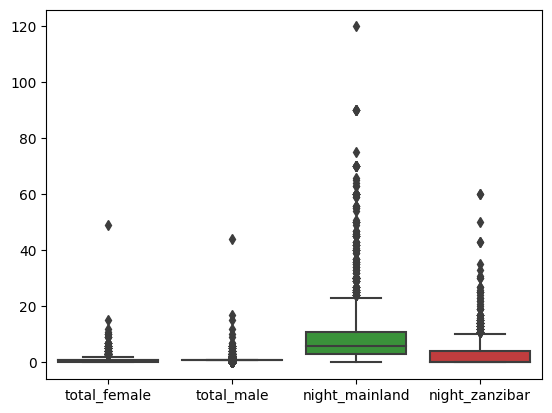

In [80]:
sns.boxplot(df_tanzania_train.drop("total_cost", axis=1))

<Axes: ylabel='night_zanzibar'>

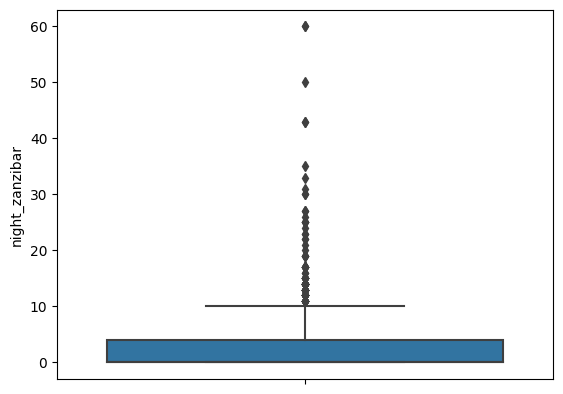

In [81]:
sns.boxplot(df_tanzania_train, y ='night_zanzibar')

<Axes: ylabel='night_mainland'>

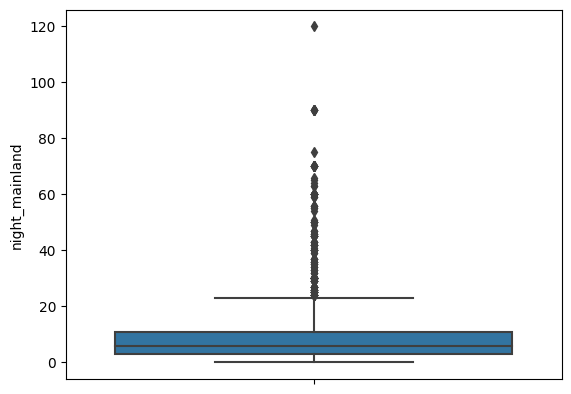

In [82]:
sns.boxplot(df_tanzania_train, y ='night_mainland')

In [83]:
stats_mainland = df_tanzania_train["night_mainland"].describe()
stats_mainland

count    3606.000000
mean        8.430948
std        10.145766
min         0.000000
25%         3.000000
50%         6.000000
75%        11.000000
max       120.000000
Name: night_mainland, dtype: float64

In [84]:
Q1 = stats_mainland['25%']
Q2 = stats_mainland['50%']
Q3 = stats_mainland['75%']
IQR = Q3 - Q1
lower_whisker = max(df_tanzania_train.night_mainland[df_tanzania_train.night_mainland >= (Q1 - 1.5 * IQR)].min(), df_tanzania_train.night_mainland.min())
upper_whisker = min(df_tanzania_train.night_mainland[df_tanzania_train.night_mainland <= (Q3 + 1.5 * IQR)].max(), df_tanzania_train.night_mainland.max())
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

Lower Whisker: 0.0
Upper Whisker: 23.0


In [85]:
#cleaned from outliers
df_tanzania_train = df_tanzania_train.query("night_mainland <= 23")

<Axes: ylabel='night_zanzibar'>

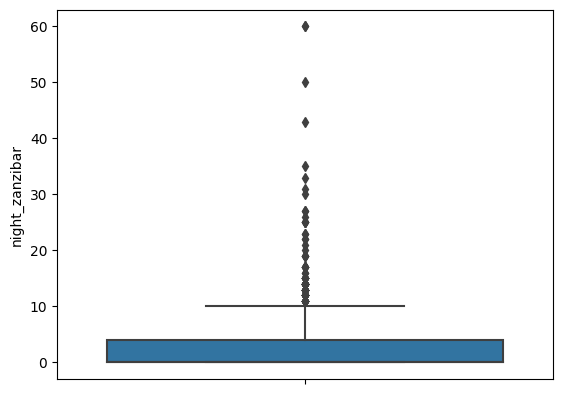

In [86]:
sns.boxplot(df_tanzania_train, y ='night_zanzibar')

In [87]:
stats_zanzibar = df_tanzania_train["night_zanzibar"].describe()
stats_zanzibar

count    3402.000000
mean        2.340094
std         4.205453
min         0.000000
25%         0.000000
50%         0.000000
75%         4.000000
max        60.000000
Name: night_zanzibar, dtype: float64

In [88]:
Q1 = stats_zanzibar['25%']
Q2 = stats_zanzibar['50%']
Q3 = stats_zanzibar['75%']
IQR = Q3 - Q1
lower_whisker = max(df_tanzania_train.night_zanzibar[df_tanzania_train.night_zanzibar >= (Q1 - 1.5 * IQR)].min(), df_tanzania_train.night_zanzibar.min())
upper_whisker = min(df_tanzania_train.night_zanzibar[df_tanzania_train.night_zanzibar <= (Q3 + 1.5 * IQR)].max(), df_tanzania_train.night_zanzibar.max())
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

Lower Whisker: 0.0
Upper Whisker: 10.0


In [89]:
#cleaned from outliers
df_tanzania_train = df_tanzania_train.query("night_zanzibar <= 10")

<Axes: >

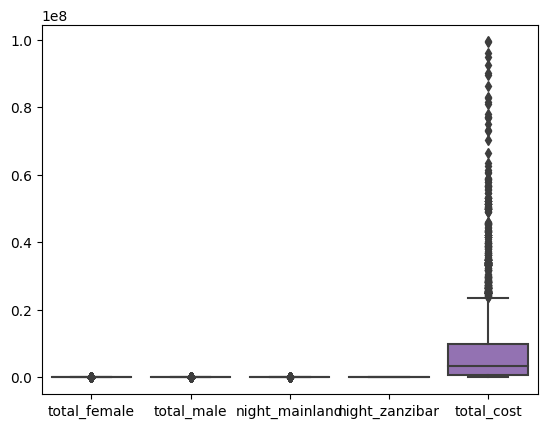

In [90]:
sns.boxplot(df_tanzania_train)

<Axes: ylabel='total_female'>

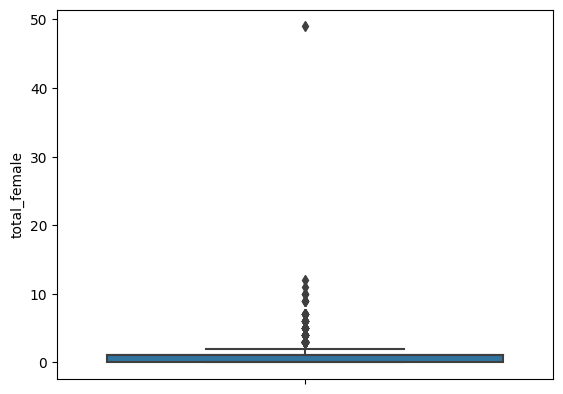

In [91]:
sns.boxplot(df_tanzania_train, y ='total_female')

In [92]:
stats_female = df_tanzania_train["total_female"].describe()
stats_female

count    3267.000000
mean        0.929293
std         1.354119
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        49.000000
Name: total_female, dtype: float64

In [93]:

Q1 = stats_female['25%']
Q2 = stats_female['50%']
Q3 = stats_female['75%']
IQR = Q3 - Q1
lower_whisker = max(df_tanzania_train.total_female[X_train.total_female >= (Q1 - 1.5 * IQR)].min(), df_tanzania_train.total_female.min())
upper_whisker = min(df_tanzania_train.total_female[X_train.total_female <= (Q3 + 1.5 * IQR)].max(),df_tanzania_train.total_female.max())
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

Lower Whisker: 0.0
Upper Whisker: 2.0


In [94]:
#cleaned from outliers
df_tanzania_train = df_tanzania_train.query("total_female <= 2")

In [95]:
df_tanzania_train.shape

(3090, 21)

<Axes: ylabel='total_cost'>

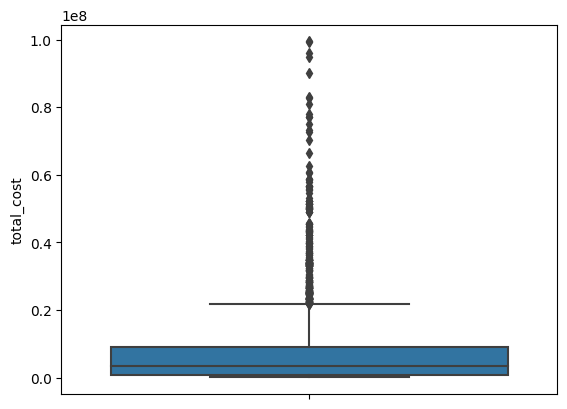

In [96]:
sns.boxplot(df_tanzania_train, y ='total_cost')

In [97]:
stats_cost = df_tanzania_train["total_cost"].describe()
stats_cost


count    3.090000e+03
mean     7.490464e+06
std      1.129865e+07
min      4.900000e+04
25%      6.798810e+05
50%      3.315000e+06
75%      9.141112e+06
max      9.953288e+07
Name: total_cost, dtype: float64

In [98]:
Q1 = stats_cost['25%']
Q2 = stats_cost['50%']
Q3 = stats_cost['75%']
IQR = Q3 - Q1
lower_whisker = max(df_tanzania_train.total_cost[df_tanzania_train.total_cost >= (Q1 - 1.5 * IQR)].min(), df_tanzania_train.total_cost.min())
upper_whisker = min(df_tanzania_train.total_cost[df_tanzania_train.total_cost <= (Q3 + 1.5 * IQR)].max(), df_tanzania_train.total_cost.max())
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")


Lower Whisker: 49000.0
Upper Whisker: 21810040.0


In [99]:
#cleaned from outliers
df_tanzania_train = df_tanzania_train.query("total_cost <= 21810040.0")
df_tanzania_train.shape

(2823, 21)

<Axes: >

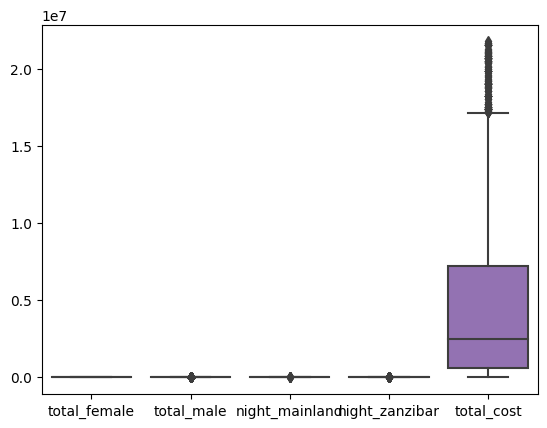

In [100]:
sns.boxplot(df_tanzania_train)

In [101]:
df_tanzania_train.shape

(2823, 21)

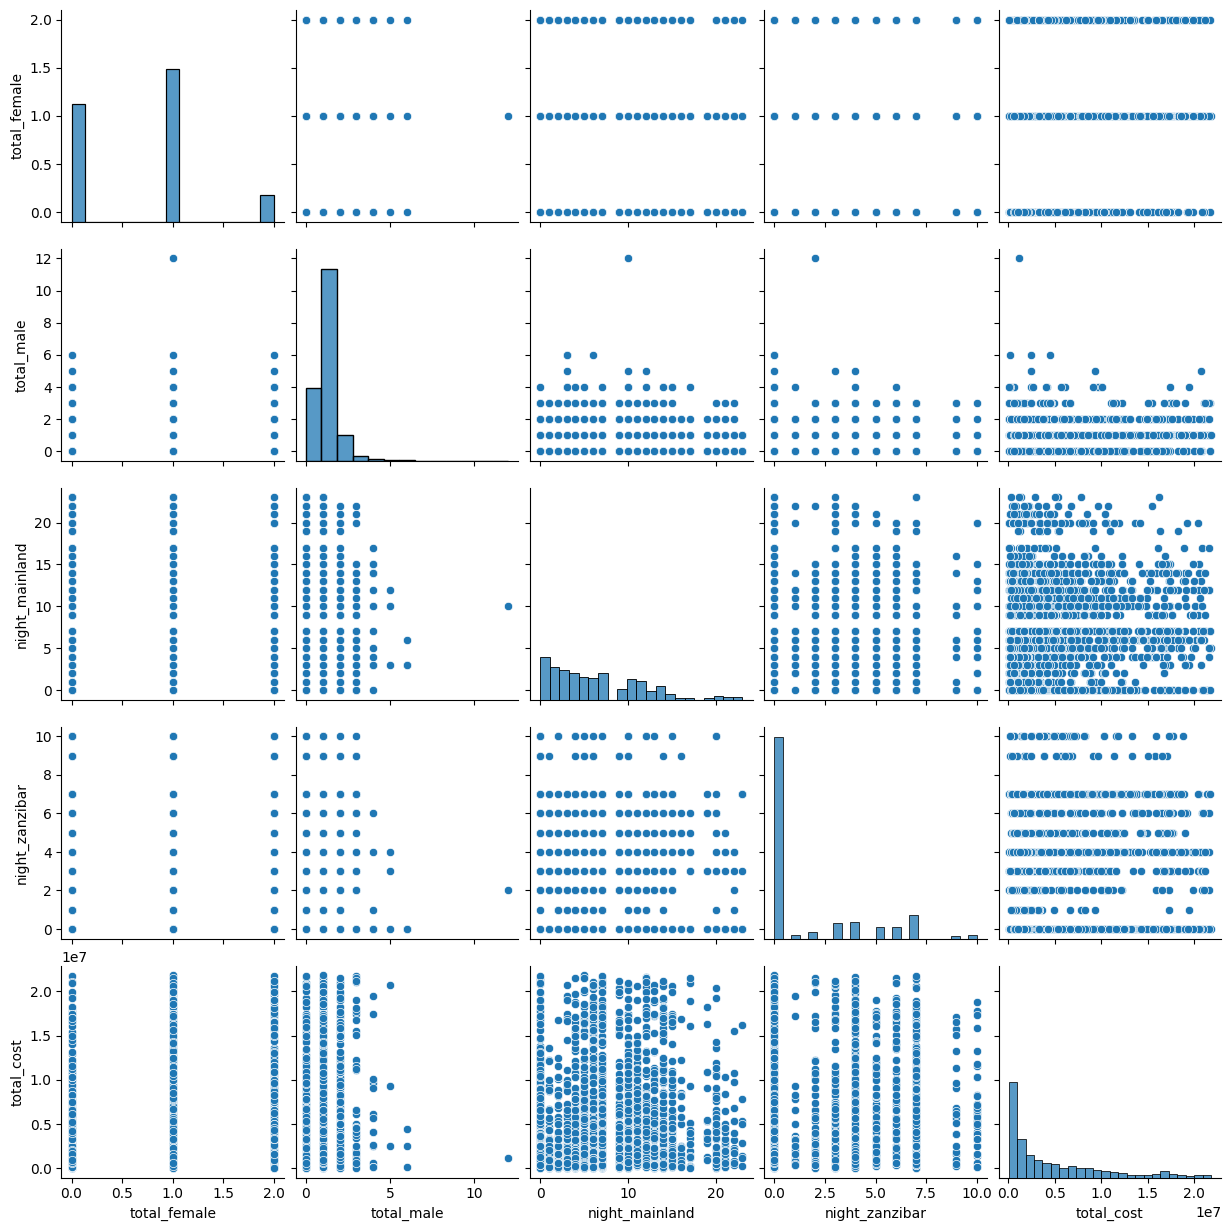

In [102]:
sns.pairplot(df_tanzania_train)

<Axes: >

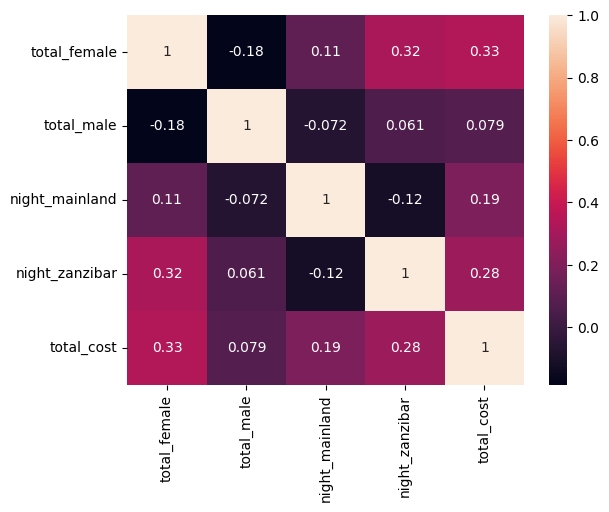

In [103]:
correlations = df_tanzania_train.corr(numeric_only=True)
sns.heatmap(correlations, annot=True)

# if women travel, then money is spent


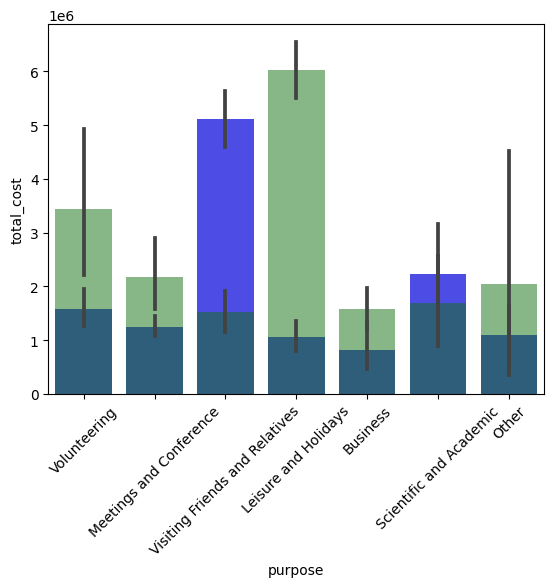

In [104]:
sns.barplot(df_tanzania_train.query("total_female==0"), x="purpose", y="total_cost", color = "blue", alpha=0.8)
sns.barplot(df_tanzania_train.query("total_male==0"), x="purpose", y="total_cost", color = "green", alpha=0.5)
plt.xticks(rotation=45)


plt.show()

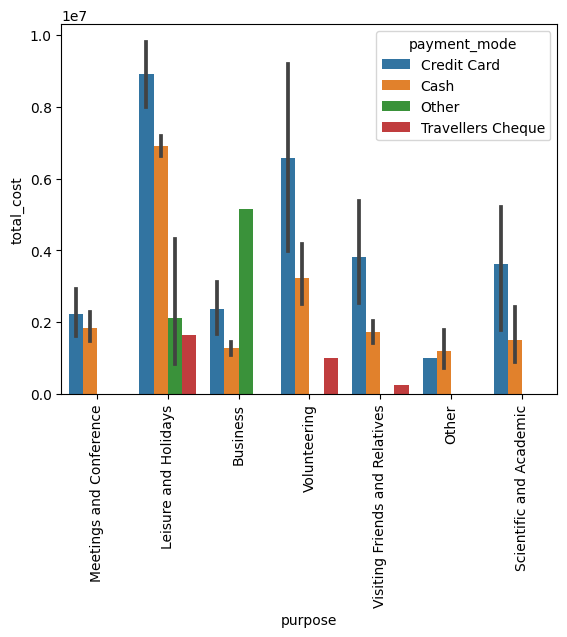

In [105]:
sns.barplot(df_tanzania_train, hue="payment_mode", x="purpose", y="total_cost")
plt.xticks(rotation=90)


plt.show()

In [106]:
df_tanzania_train.columns

Index(['country', 'age_group', 'travel_with', 'total_female', 'total_male',
       'purpose', 'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode',
       'first_trip_tz', 'total_cost'],
      dtype='object')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Wildlife tourism'),
  Text(1, 0, 'Beach tourism'),
  Text(2, 0, 'Hunting tourism'),
  Text(3, 0, 'Mountain climbing'),
  Text(4, 0, 'Cultural tourism'),
  Text(5, 0, 'Conference tourism'),
  Text(6, 0, 'Bird watching'),
  Text(7, 0, 'business'),
  Text(8, 0, 'Diving and Sport Fishing')])

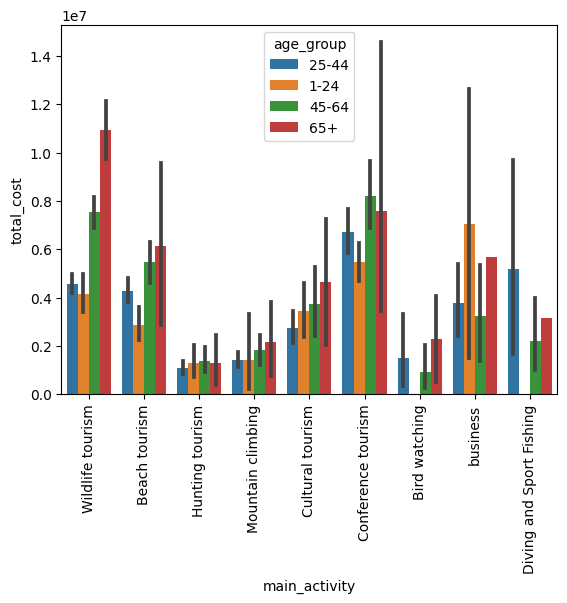

In [107]:
sns.barplot(df_tanzania_train, x="main_activity", y="total_cost", hue="age_group")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Meetings and Conference'),
  Text(1, 0, 'Leisure and Holidays'),
  Text(2, 0, 'Business'),
  Text(3, 0, 'Volunteering'),
  Text(4, 0, 'Visiting Friends and Relatives'),
  Text(5, 0, 'Other'),
  Text(6, 0, 'Scientific and Academic')])

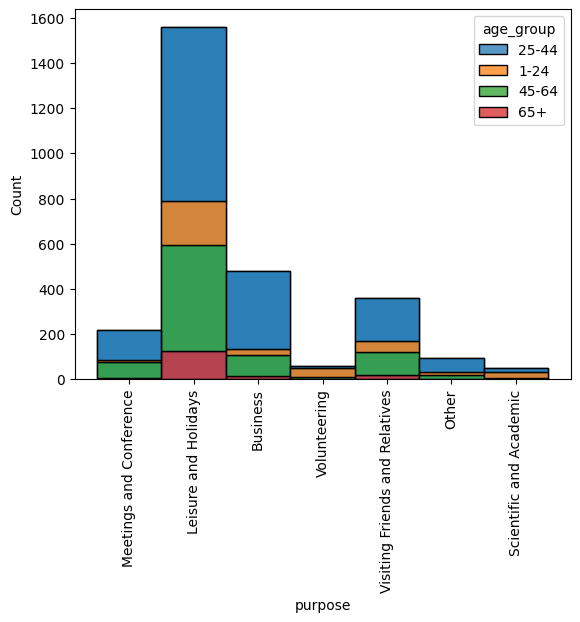

In [108]:
#top_languages = df_psycopg['programming_language_recommended'].value_counts().head(15).index
#print(top_languages)
fig, ax = plt.subplots()
sns.histplot(data=df_tanzania_train, x="purpose",ax=ax)
sns.histplot(data=df_tanzania_train, x="purpose", hue="age_group", multiple="stack",ax=ax)
plt.xticks(rotation=90)

In [109]:
df_tanzania_train["age_group"].unique()

array(['25-44', '1-24', '45-64', '65+'], dtype=object)

In [110]:
df_tanzania_train["age_group"].unique()

array(['25-44', '1-24', '45-64', '65+'], dtype=object)

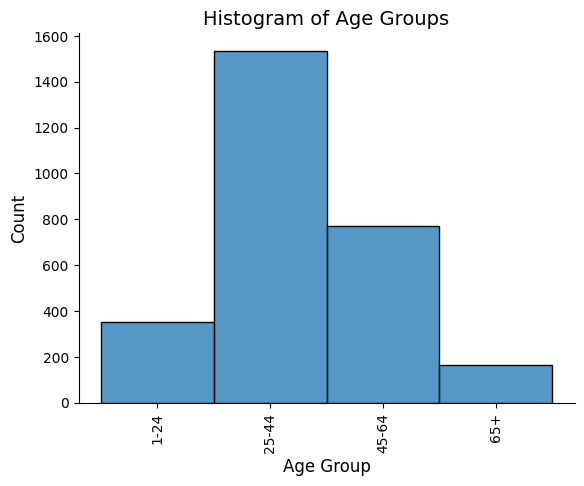

In [111]:
custom_order = ['1-24', '25-44', '45-64', "65+"]  # Example order

df_tanzania_train['age_group'].astype(str)
# Convert 'age_group' into a categorical variable with the custom order
df_tanzania_train['age_group'] = pd.Categorical(
    df_tanzania_train['age_group'], 
    categories=custom_order, 
    ordered=True
)

# Plot the histogram
sns.histplot(data=df_tanzania_train, x='age_group', stat='count', palette="viridis")

# Aesthetics
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Age Groups", fontsize=14)
plt.xticks(rotation=90)
sns.despine()


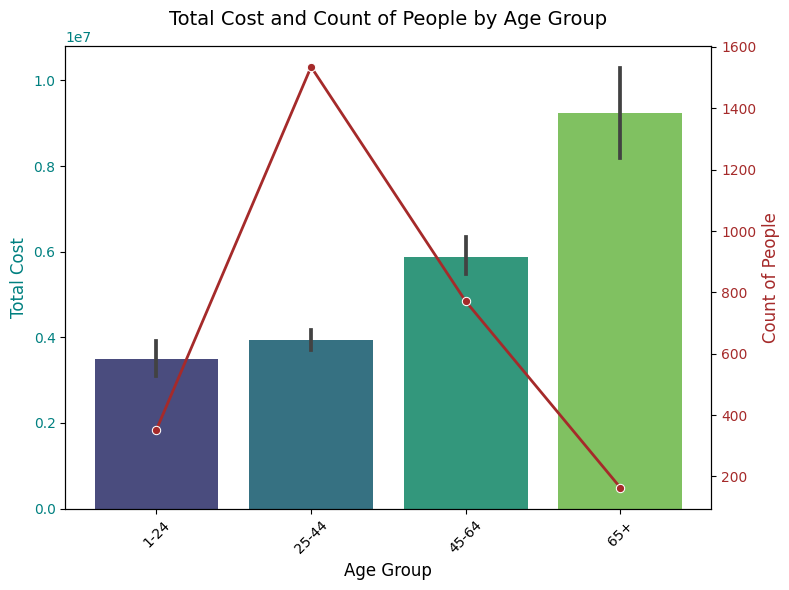

In [112]:
# Group by age_group to calculate total cost and counts
grouped = df_tanzania_train.groupby('age_group').agg(
    total_cost=('total_cost', 'sum'),
    count=('total_cost', 'count')
).reindex(['1-24', '25-44', '45-64', "65+"])  # Ensure custom order

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart for total cost
sns.barplot(x=df_tanzania_train.age_group, y=df_tanzania_train.total_cost, ax=ax1, palette="viridis")
ax1.set_ylabel("Total Cost", fontsize=12, color="teal")
ax1.set_xlabel("Age Group", fontsize=12)
ax1.tick_params(axis='y', labelcolor="teal")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Total Cost and Count of People by Age Group", fontsize=14, pad=15)

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the line chart for the count of people
sns.lineplot(x=grouped.index, y=grouped['count'], ax=ax2, color="brown", marker="o", linewidth=2)
ax2.set_ylabel("Count of People", fontsize=12, color="brown")
ax2.tick_params(axis='y', labelcolor="brown")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

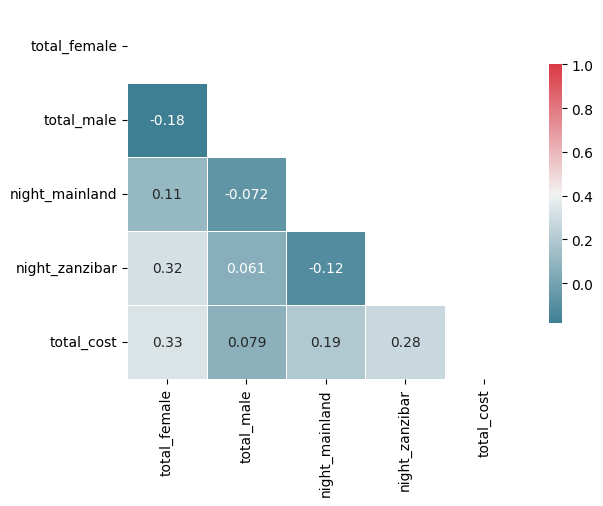

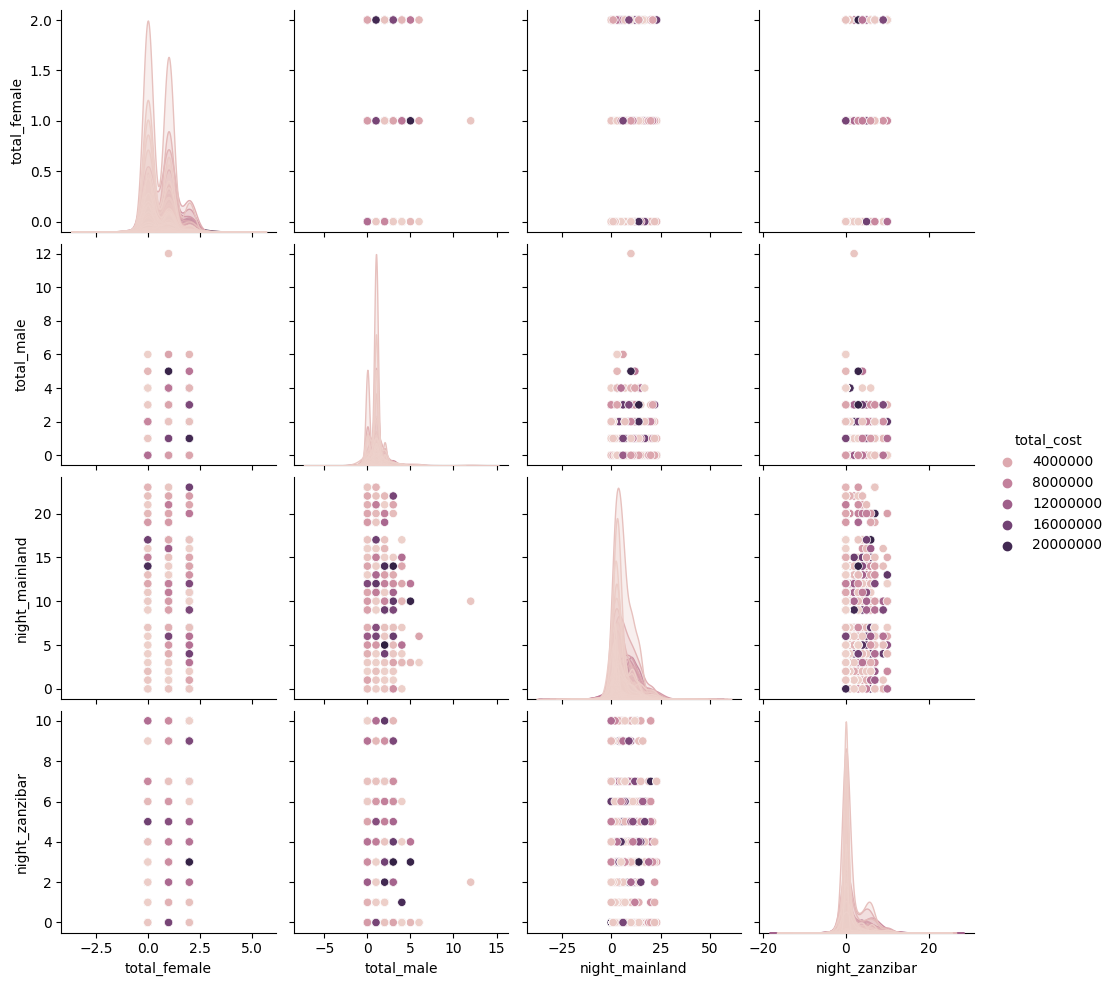

In [113]:

# Compute correlations
correlations = df_tanzania_train.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, annot=True,
            linewidths=.5, cbar_kws={"shrink": .7});
_ = sns.pairplot(df_tanzania_train, hue="total_cost")

most people don't go to zanzibar, those that go, spend loooots of money

In [114]:
df_tanzania_train.isna().sum()

country                    0
age_group                  0
travel_with              723
total_female               0
total_male                 0
purpose                    0
main_activity              0
info_source                0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
night_mainland             0
night_zanzibar             0
payment_mode               0
first_trip_tz              0
total_cost                 0
dtype: int64

In [115]:
def travel_with_alone(row):
    travel_alone = row['travel_with']
    male = row['total_male']
    female = row['total_female']
    
    # Only process rows where 'travel_with' is NaN
    if pd.isnull(travel_alone):
        # Check if the person traveled alone
        if male == 1 and female == 0:  # One male, no females
            return "Alone"
        elif male == 0 and female == 1:  # One female, no males
            return "Alone"
        else:  # Any other combination means "Unknown"
            return "Unknown"
    else:
        # Keep the existing value if not NaN
        return travel_alone

In [116]:
# Apply the function to the DataFrame
df_tanzania_train['travel_with'] = df_tanzania_train.apply(travel_with_alone, axis=1)

# Check the number of "Unknown" values
unknown_count = (df_tanzania_train['travel_with'] == 'Unknown').sum()
print(f"Number of 'Unknown' entries: {unknown_count}")

# Check the number of 'Alone' entries for confirmation
alone_count = (df_tanzania_train['travel_with'] == 'Alone').sum()
print(f"Number of 'Alone' entries: {alone_count}")

# Verify that the number of missing values matches the sum of 'Alone' + 'Unknown'
processed_missing_count = unknown_count + alone_count
print(f"Total processed missing values (Alone + Unknown): {processed_missing_count}")

Number of 'Unknown' entries: 14
Number of 'Alone' entries: 1538
Total processed missing values (Alone + Unknown): 1552


In [117]:
# Count all values in 'travel_with' column
print(df_tanzania_train['travel_with'].value_counts())

# Specifically get the count of 'Unknown'
unknown_count = df_tanzania_train['travel_with'].value_counts().get('Unknown', 0)
print(f"Number of 'Unknown' entries: {unknown_count}")

travel_with
Alone                  1538
Spouse                  565
Friends/Relatives       480
Spouse and Children     129
Children                 97
Unknown                  14
Name: count, dtype: int64
Number of 'Unknown' entries: 14


In [129]:
df_tanzania_train

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,total_cost
3075,SOUTH AFRICA,25-44,Alone,0.0,1.0,Meetings and Conference,Wildlife tourism,"Friends, relatives",Independent,No,...,No,No,No,No,No,2.0,0.0,Credit Card,No,1657500.0
2304,POLAND,1-24,Spouse,1.0,1.0,Leisure and Holidays,Beach tourism,"Radio, TV, Web",Independent,No,...,No,No,No,No,No,3.0,6.0,Cash,Yes,2539290.0
1196,IRELAND,45-64,Friends/Relatives,0.0,2.0,Business,Wildlife tourism,"Radio, TV, Web",Independent,No,...,No,No,No,No,No,2.0,0.0,Credit Card,Yes,680799.0
620,UNITED KINGDOM,45-64,Alone,1.0,0.0,Volunteering,Hunting tourism,"Travel, agent, tour operator",Independent,No,...,No,No,No,No,No,3.0,0.0,Cash,No,1077375.0
1215,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Beach tourism,"Newspaper, magazines,brochures",Package Tour,Yes,...,Yes,Yes,Yes,Yes,Yes,7.0,7.0,Cash,Yes,17072250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,FRANCE,25-44,Spouse and Children,2.0,3.0,Leisure and Holidays,Wildlife tourism,"Radio, TV, Web",Independent,No,...,No,No,No,No,No,9.0,9.0,Cash,Yes,15083250.0
3444,JAPAN,45-64,Alone,0.0,1.0,Business,Wildlife tourism,"Travel, agent, tour operator",Independent,No,...,No,No,No,No,No,2.0,0.0,Cash,No,1657500.0
3092,KENYA,45-64,Alone,0.0,1.0,Leisure and Holidays,Cultural tourism,"Friends, relatives",Independent,No,...,No,No,No,No,No,10.0,0.0,Cash,Yes,675000.0
3772,ZIMBABWE,25-44,Alone,0.0,1.0,Other,Hunting tourism,"Friends, relatives",Independent,No,...,No,No,No,No,No,1.0,0.0,Cash,No,994500.0


<Axes: xlabel='travel_with', ylabel='Count'>

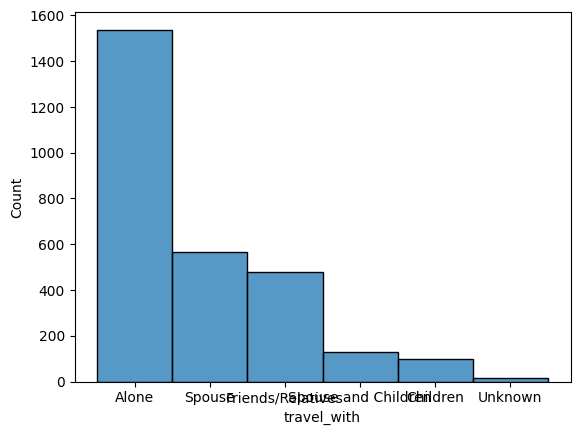

In [128]:
sns.histplot(df_tanzania_train, x="travel_with")

In [130]:
df_tanzania_train.isna().sum()

country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
total_cost               0
dtype: int64

In [131]:
df_tanzania_train.columns

Index(['country', 'age_group', 'travel_with', 'total_female', 'total_male',
       'purpose', 'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode',
       'first_trip_tz', 'total_cost'],
      dtype='object')

In [132]:
#Encoding
col_encode = ['country', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement','payment_mode', 'most_impressing']
col_map = ['package_transport_int', 'package_accomodation', 'package_food','package_transport_tz', 'package_sightseeing', 'package_guided_tour','package_insurance','first_trip_tz',]


In [133]:
# Replace 'yes' with 1 and 'no' with 0 in specified columns 
df_tanzania_train[col_map] = df_tanzania_train[col_map].replace({'Yes': 1, 'No': 0}) 
print(df_tanzania_train)

                       country age_group          travel_with  total_female   
3075              SOUTH AFRICA     25-44                Alone           0.0  \
2304                    POLAND      1-24               Spouse           1.0   
1196                   IRELAND     45-64    Friends/Relatives           0.0   
620             UNITED KINGDOM     45-64                Alone           1.0   
1215            UNITED KINGDOM     25-44               Spouse           1.0   
...                        ...       ...                  ...           ...   
3171                    FRANCE     25-44  Spouse and Children           2.0   
3444                     JAPAN     45-64                Alone           0.0   
3092                     KENYA     45-64                Alone           0.0   
3772                  ZIMBABWE     25-44                Alone           0.0   
860   UNITED STATES OF AMERICA       65+               Spouse           1.0   

      total_male                  purpose     main_

In [134]:
df_tanzania_train.corr(numeric_only = True)

,total_female,total_male,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,total_cost
total_female,1.000000,-0.183350,0.239864,0.270663,0.266404,0.256575,0.206183,0.201040,0.169103,0.108994,0.315349,0.243102,0.334676
total_male,-0.183350,1.000000,0.073512,-0.008315,-0.018291,-0.014796,-0.017183,-0.024458,0.032890,-0.071773,0.060669,-0.009439,0.078972
package_transport_int,0.239864,0.073512,1.000000,0.645398,0.599529,0.569546,0.384058,0.394483,0.475472,-0.023111,0.310890,0.248818,0.451491
package_accomodation,0.270663,-0.008315,0.645398,1.000000,0.935470,0.868189,0.710307,0.744048,0.441025,0.105387,0.214041,0.410312,0.558641
package_food,0.266404,-0.018291,0.599529,0.935470,1.000000,0.842284,0.684583,0.724655,0.444202,0.082587,0.206153,0.396632,0.540176
package_transport_tz,0.256575,-0.014796,0.569546,0.868189,0.842284,1.000000,0.698592,0.706974,0.443642,0.112415,0.193016,0.387455,0.530382
package_sightseeing,0.206183,-0.017183,0.384058,0.710307,0.684583,0.698592,1.000000,0.789857,0.365141,0.193410,0.031099,0.332404,0.478123
package_guided_tour,0.201040,-0.024458,0.394483,0.744048,0.724655,0.706974,0.789857,1.000000,0.413739,0.169567,0.058777,0.357943,0.472887
package_insurance,0.169103,0.032890,0.475472,0.441025,0.444202,0.443642,0.365141,0.413739,1.000000,-0.039761,0.206850,0.209388,0.316422
night_mainland,0.108994,-0.071773,-0.023111,0.105387,0.082587,0.112415,0.193410,0.169567,-0.039761,1.000000,-0.118512,0.121677,0.191437


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'total_female'),
  Text(1, 0, 'total_male'),
  Text(2, 0, 'package_transport_int'),
  Text(3, 0, 'package_accomodation'),
  Text(4, 0, 'package_food'),
  Text(5, 0, 'package_transport_tz'),
  Text(6, 0, 'package_sightseeing'),
  Text(7, 0, 'package_guided_tour'),
  Text(8, 0, 'package_insurance'),
  Text(9, 0, 'night_mainland'),
  Text(10, 0, 'night_zanzibar'),
  Text(11, 0, 'first_trip_tz'),
  Text(12, 0, 'total_cost')])

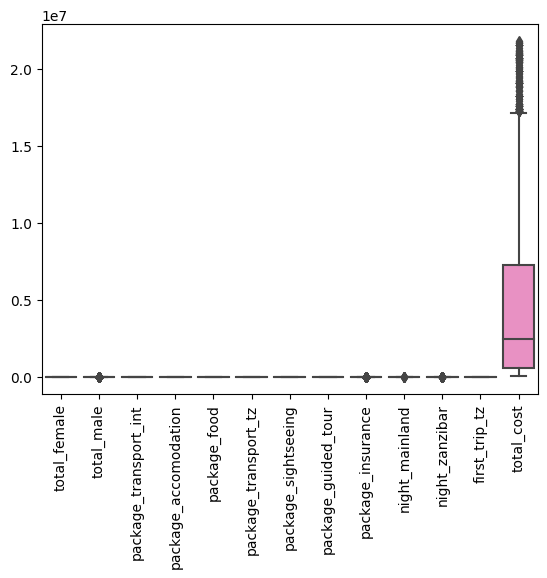

In [135]:
sns.boxplot(df_tanzania_train)
plt.xticks(rotation=90)

In [137]:
#OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

In [138]:
#Encoding
col_encode = ['country', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement','payment_mode']
df_tanzania_train[col_encode].nunique() 
ohe.fit(df_tanzania_train[col_encode]) 
t = ohe.transform(df_tanzania_train[col_encode])


In [139]:
ohe.get_feature_names_out() 

array(['country_AUSTRALIA', 'country_AUSTRIA', 'country_BELGIUM',
       'country_BRAZIL', 'country_BURGARIA', 'country_BURUNDI',
       'country_CANADA', 'country_CAPE VERDE', 'country_CHILE',
       'country_CHINA', 'country_COLOMBIA', 'country_CONGO',
       'country_CROATIA', 'country_CYPRUS', 'country_CZECH REPUBLIC',
       'country_DENMARK', 'country_DJIBOUT', 'country_DRC',
       'country_EGYPT', 'country_ESTONIA', 'country_ETHIOPIA',
       'country_FINLAND', 'country_FRANCE', 'country_GERMANY',
       'country_GREECE', 'country_HUNGARY', 'country_INDIA',
       'country_INDONESIA', 'country_IRAN', 'country_IRAQ',
       'country_IRELAND', 'country_ISRAEL', 'country_ITALY',
       'country_IVORY COAST', 'country_JAPAN', 'country_KENYA',
       'country_KOREA', 'country_KUWAIT', 'country_LATVIA',
       'country_LEBANON', 'country_LESOTHO', 'country_LITHUANIA',
       'country_LUXEMBOURG', 'country_MALAWI', 'country_MALAYSIA',
       'country_MALT', 'country_MONTENEGRO', 'coun

In [140]:
df_tanzania_train.head()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,total_cost
3075,SOUTH AFRICA,25-44,Alone,0.0,1.0,Meetings and Conference,Wildlife tourism,"Friends, relatives",Independent,0,...,0,0,0,0,0,2.0,0.0,Credit Card,0,1657500.0
2304,POLAND,1-24,Spouse,1.0,1.0,Leisure and Holidays,Beach tourism,"Radio, TV, Web",Independent,0,...,0,0,0,0,0,3.0,6.0,Cash,1,2539290.0
1196,IRELAND,45-64,Friends/Relatives,0.0,2.0,Business,Wildlife tourism,"Radio, TV, Web",Independent,0,...,0,0,0,0,0,2.0,0.0,Credit Card,1,680799.0
620,UNITED KINGDOM,45-64,Alone,1.0,0.0,Volunteering,Hunting tourism,"Travel, agent, tour operator",Independent,0,...,0,0,0,0,0,3.0,0.0,Cash,0,1077375.0
1215,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Beach tourism,"Newspaper, magazines,brochures",Package Tour,1,...,1,1,1,1,1,7.0,7.0,Cash,1,17072250.0


In [141]:
# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_train_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())
df_tanzania_train_encode.head()
# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_encode], axis=1)
df_tanzania_train.drop(columns=col_encode,inplace=True)


In [142]:
df_tanzania_train.head()
df_tanzania_train.shape

(2823, 134)

In [ ]:
#Scale this won't use
#from sklearn.preprocessing import StandardScaler
#col_scale = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']
#scaler = StandardScaler()
#scaler.fit(X_train[col_scale])

In [ ]:
#t = scaler.transform(X_train[col_scale])

In [144]:
from sklearn.preprocessing import MinMaxScaler
col_scale_MinMax = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']
scaler_MinMax = MinMaxScaler()
scaler_MinMax.fit(df_tanzania_train[col_scale_MinMax])

MinMaxScaler()

In [145]:
t_MinMax = scaler_MinMax.transform(df_tanzania_train[col_scale_MinMax])

In [146]:
df_tanzania_train_scaled = pd.DataFrame(t_MinMax, columns= scaler_MinMax.get_feature_names_out())
df_tanzania_train_scaled.head()
# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_scaled], axis=1)
df_tanzania_train.drop(columns=col_scale_MinMax,inplace=True)

In [147]:
df_tanzania_train.head()

,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,first_trip_tz,total_cost,country_AUSTRALIA,...,"info_source_Radio, TV, Web",info_source_Tanzania Mission Abroad,info_source_Trade fair,"info_source_Travel, agent, tour operator",info_source_inflight magazines,info_source_others,tour_arrangement_Package Tour,payment_mode_Credit Card,payment_mode_Other,payment_mode_Travellers Cheque
0,0,0,0,0,0,0,0,0,1657500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0,0,0,0,0,0,1,2539290.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,1,680799.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,0,0,0,0,0,0,0,1077375.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1,1,1,1,1,1,17072250.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [151]:
X_train = df_tanzania_train.drop("total_cost", axis=1)
y_train = df_tanzania_train["total_cost"]

## Baseline Model